# Installation

In [1]:
import os
import pathlib
import time
import datetime

import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from IPython import display

# Setup GPU

In [2]:
gpus = tf.config.list_physical_devices("GPU")
print("GPUS: {}".format(gpus))
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

GPUS: []


# Setup Custom Dataset

In [3]:
faces = tfds.load("faces")["train"].take(300)
outlines = tfds.load("outlines")["train"].take(300)

2022-02-27 21:17:31.058132: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Constants

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
@tf.function
def random_jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    image = tf.image.random_flip_left_right(image)
    return image

In [6]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [7]:
def preprocess_image(image):
    image = image["image"]
    image = random_jitter(image)
    image = normalize(image)
    return image

# Input Pipeline

In [8]:
faces = faces.map(preprocess_image).batch(BATCH_SIZE)
outlines = outlines.map(preprocess_image).batch(BATCH_SIZE)

In [9]:
sample_face = next(iter(faces))[0]
sample_outline = next(iter(outlines))[0]

2022-02-27 21:17:31.308428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-02-27 21:17:31.358878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
train_dataset = tf.data.Dataset.zip((outlines, faces))

# Setup Generator

In [11]:
OUTPUT_CHANNELS = 3

In [12]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters,
                                      size,
                                      strides=2,
                                      padding="same",
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [13]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(sample_outline, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters,
                                               size,
                                               strides=2,
                                               padding="same",
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [15]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [16]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                           4,
                                           strides=2,
                                           padding="same",
                                           kernel_initializer=initializer,
                                           activation="tanh")
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

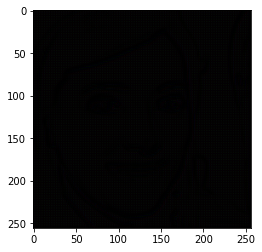

In [17]:
generator = Generator()
gen_output = generator(sample_outline[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

# Setup Discriminator

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name="input_image")
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name="target_image")
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512,
                                  4,
                                  strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

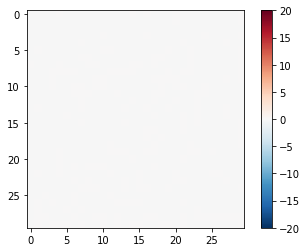

In [19]:
discriminator = Discriminator()
disc_out = discriminator([sample_outline[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()

# Setup Loss Functions

In [20]:
LAMBDA = 100

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [23]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Setup Optimizers

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Setup Checkpoints

In [25]:
checkpoint_dir = "./checkpoints/pix2pix"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

Latest checkpoint restored!


# Train Model

In [26]:
def generate_images(model, image, target):
    prediction = model(image, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [image[0], target[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicted Image"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.show()

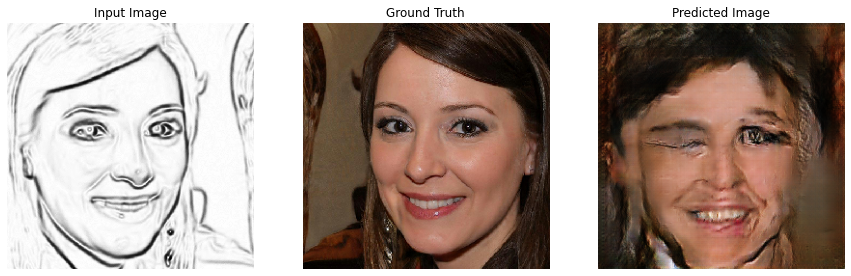

In [27]:
generate_images(generator, sample_outline[tf.newaxis, ...], sample_face[tf.newaxis, ...])

In [28]:
log_dir = "./logs/pix2pix"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [29]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step=step//1000)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step=step//1000)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step=step//1000)
        tf.summary.scalar("disc_loss", disc_loss, step=step//1000)

In [30]:
def fit(train_dataset, steps):
    start = time.time()

    for step, (input_image, target) in train_dataset.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f"Time taken for 1000 steps: {time.time()-start:.2f} sec\n")

            start = time.time()
            generate_images(generator, input_image, target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training Step
        if (step + 1) % 10 == 0:
            print(".", end="", flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [31]:
enable_training = False
if enable_training:
    fit(train_dataset, steps=40000)

# Test Output

In [32]:
@tf.function
def load_image(filename):
    raw = tf.io.read_file(filename)
    image = tf.image.decode_png(raw, channels=3)
    image = preprocess_image({"image": image})
    return image

In [33]:
def predict_images(model, image):
    prediction = model(image, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [image[0], prediction[0]]
    title = ["Input Image", "Predicted Image"]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.show()
    output = tf.squeeze(prediction * 0.5 + 0.5)
    output = tf.image.convert_image_dtype(output, tf.uint8)
    return output

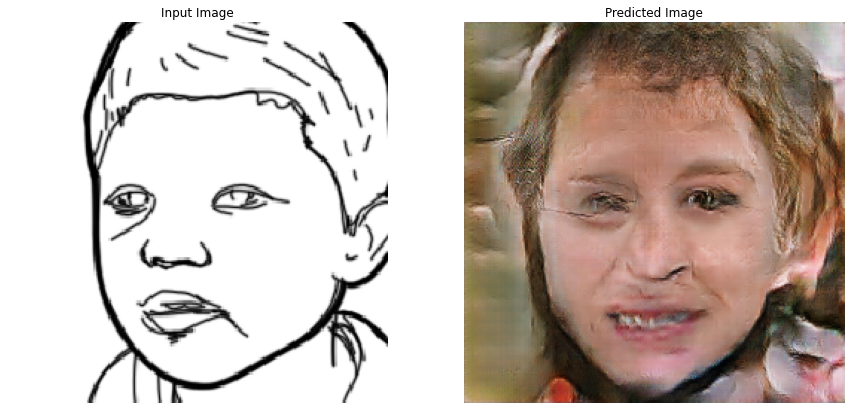

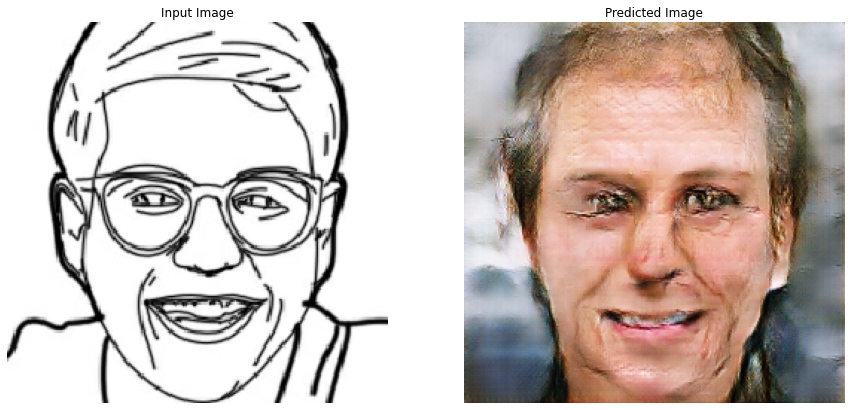

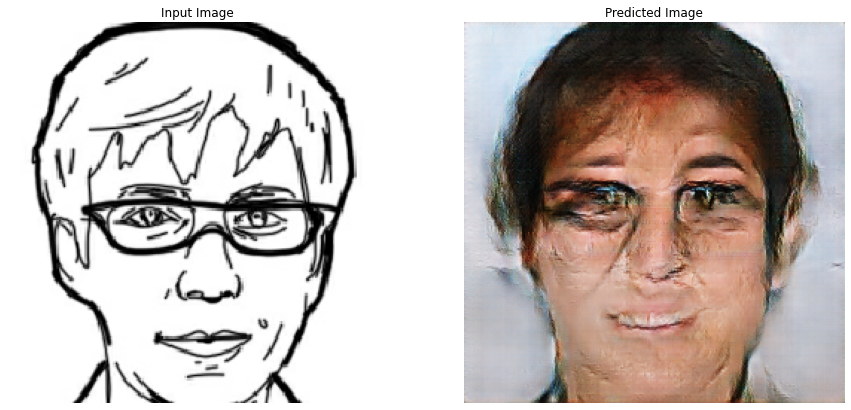

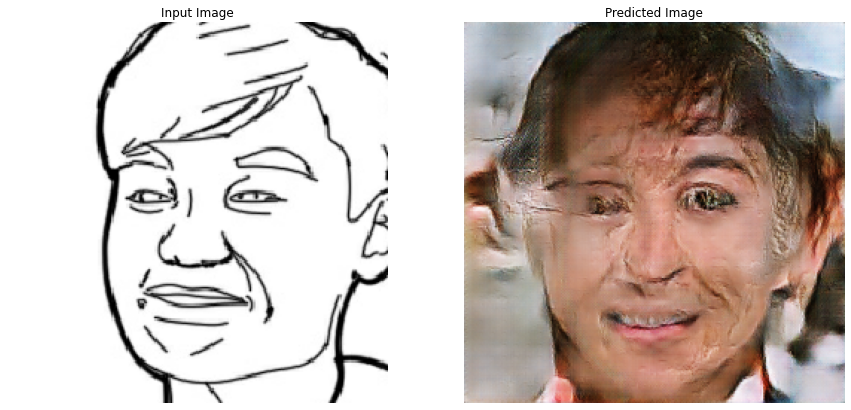

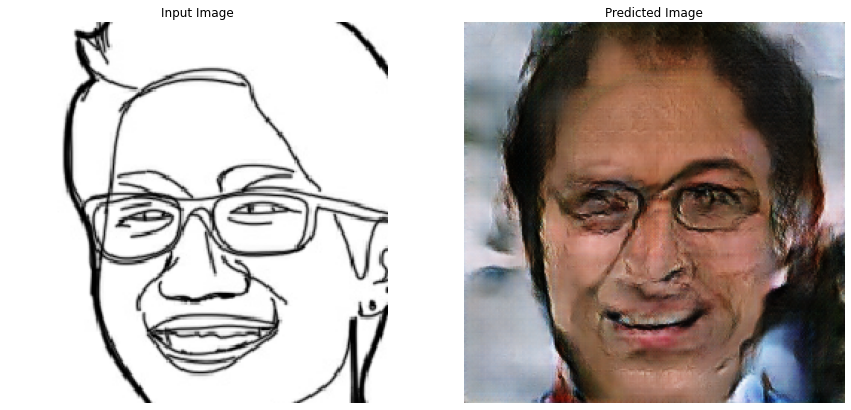

In [34]:
test_dir = os.path.join(os.getcwd(), "assets/sketches")
out_dir = os.path.join(os.getcwd(), "assets/faces")
for file in os.listdir(test_dir):
    filename = os.path.join(test_dir, file)
    test_image = load_image(filename)
    output = predict_images(generator, test_image[tf.newaxis, ...])
    tf.io.write_file(os.path.join(out_dir, file), tf.image.encode_jpeg(output))